
# MNIST Pruning Experiments (FC & CNN)
1) Train MLP and CNN on MNIST, prune at `0.3, 0.5, 0.7, 0.9, 0.99`, then fine-tune.  
2) Visualize MNIST and weight histograms before/after pruning.


In [ ]:
# Setup
import os, random, copy, gc
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.prune as prune
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

100%|██████████| 9.91M/9.91M [00:00<00:00, 57.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.65MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.60MB/s]


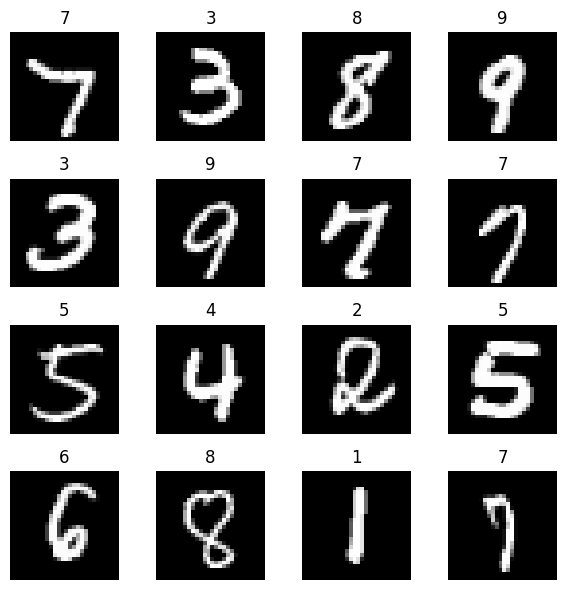

In [ ]:

# Data & sample visualization
BATCH_SIZE = 128
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_ds = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_ds  = datasets.MNIST(root="./data", train=False, transform=transform, download=True)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

def show_samples(dataset, n=16):
    idxs = np.random.choice(len(dataset), n, replace=False)
    fig, axes = plt.subplots(4, 4, figsize=(6,6))
    for ax, i in zip(axes.flat, idxs):
        img, label = dataset[i]
        ax.imshow(img.squeeze(0), cmap="gray")
        ax.set_title(f"{label}"); ax.axis("off")
    plt.tight_layout(); plt.show()

show_samples(train_ds, n=16)


In [ ]:

# Helpers
def accuracy(model, loader, device):
    model.eval(); correct = 0; total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x).argmax(1)
            correct += (pred == y).sum().item(); total += y.size(0)
    return correct / total

def train_one_epoch(model, loader, optim_, crit, device):
    model.train(); tot=0.0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        optim_.zero_grad(); out = model(x); loss = crit(out,y)
        loss.backward(); optim_.step(); tot += loss.item()*y.size(0)
    return tot/len(loader.dataset)

def train_epochs(model, tr_loader, te_loader, optim_, crit, epochs, device):
    for ep in range(1, epochs+1):
        tl = train_one_epoch(model, tr_loader, optim_, crit, device)
        te = accuracy(model, te_loader, device)
        print(f"Epoch {ep:02d} | train_loss={tl:.4f} | test_acc={te:.4f}")

def global_sparsity(model):
    nz=0; tot=0
    for m in model.modules():
        if isinstance(m,(nn.Linear, nn.Conv2d)):
            w = m.weight.detach(); nz += torch.count_nonzero(w).item(); tot += w.numel()
    return 1.0 - (nz/tot), nz, tot

def plot_weight_hist(model, title):
    ws=[]
    for m in model.modules():
        if isinstance(m,(nn.Linear, nn.Conv2d)):
            ws.append(m.weight.detach().view(-1).cpu())
    import torch as _t
    w = _t.cat(ws,0).numpy()
    plt.figure(figsize=(6,4)); plt.hist(w, bins=100); plt.title(title)
    plt.xlabel("Weight value"); plt.ylabel("Count"); plt.tight_layout(); plt.show()

def apply_l1_unstructured_pruning(model, amount):
    params=[]
    for m in model.modules():
        if isinstance(m,(nn.Linear, nn.Conv2d)): params.append((m,"weight"))
    prune.global_unstructured(params, pruning_method=prune.L1Unstructured, amount=amount)

def remove_pruning_reparam(model):
    for m in model.modules():
        if isinstance(m,(nn.Linear, nn.Conv2d)) and hasattr(m,"weight_orig"):
            prune.remove(m,"weight")


In [ ]:

# Models
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.net = nn.Sequential(
            nn.Linear(28*28, 512), nn.ReLU(True), nn.Dropout(0.2),
            nn.Linear(512, 256), nn.ReLU(True), nn.Dropout(0.2),
            nn.Linear(256, 10),
        )
    def forward(self, x):
        return self.net(self.flatten(x))

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,32,3,1,1), nn.BatchNorm2d(32), nn.ReLU(True), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,1,1), nn.BatchNorm2d(64), nn.ReLU(True), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(nn.Flatten(), nn.Linear(64*7*7,128), nn.ReLU(True), nn.Dropout(0.3), nn.Linear(128,10))
    def forward(self,x): return self.classifier(self.features(x))


In [ ]:

# Runner
import pandas as _pd
def run_pruning_experiments(model_ctor, train_loader, test_loader, base_epochs=5, finetune_epochs=2,
                            base_lr=1e-3, finetune_lr=5e-4, prune_amounts=(0.3,0.5,0.7,0.9,0.99), label="MLP"):
    print(f"=== {label}: baseline training ===")
    model = model_ctor().to(device)
    crit = nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters(), lr=base_lr)
    train_epochs(model, train_loader, test_loader, opt, crit, base_epochs, device)
    base_acc = accuracy(model, test_loader, device)
    print(f"{label} baseline test accuracy: {base_acc:.4f}")
    base_state = copy.deepcopy(model.state_dict())

    rows=[]
    for amt in prune_amounts:
        print(f"\\n=== {label}: pruning amount={amt} ===")
        model.load_state_dict(copy.deepcopy(base_state))
        plot_weight_hist(model, f"{label} weights BEFORE pruning (amount={amt})")
        apply_l1_unstructured_pruning(model, amt)
        sparsity, nz, tot = global_sparsity(model)
        print(f"Sparsity after pruning: {sparsity:.4f} (nonzero={nz}/{tot})")
        plot_weight_hist(model, f"{label} weights AFTER pruning (amount={amt})")
        acc_p = accuracy(model, test_loader, device)
        print(f"Accuracy after pruning (pre-finetune): {acc_p:.4f}")
        opt_ft = optim.Adam(model.parameters(), lr=finetune_lr)
        train_epochs(model, train_loader, test_loader, opt_ft, crit, finetune_epochs, device)
        acc_ft = accuracy(model, test_loader, device)
        print(f"Accuracy after fine-tune: {acc_ft:.4f}")
        remove_pruning_reparam(model)
        rows.append(dict(model=label, prune_amount=amt, baseline_acc=base_acc,
                         acc_after_prune=acc_p, acc_after_finetune=acc_ft, sparsity=sparsity))
        gc.collect();
        import torch as _t
        if _t.cuda.is_available(): _t.cuda.empty_cache()
    return _pd.DataFrame(rows)


=== MLP: baseline training ===
Epoch 01 | train_loss=0.2581 | test_acc=0.9677
Epoch 02 | train_loss=0.1077 | test_acc=0.9726
Epoch 03 | train_loss=0.0813 | test_acc=0.9756
Epoch 04 | train_loss=0.0652 | test_acc=0.9779
Epoch 05 | train_loss=0.0545 | test_acc=0.9805
MLP baseline test accuracy: 0.9805
\n=== MLP: pruning amount=0.3 ===


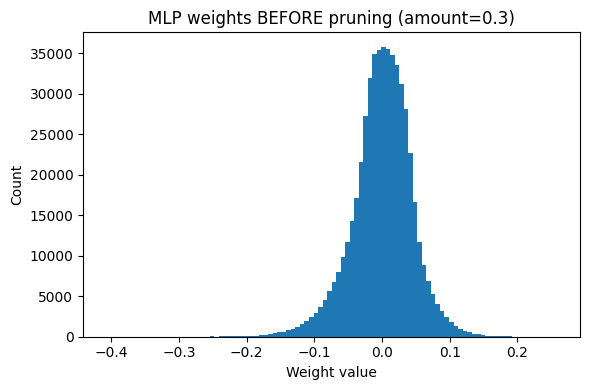

Sparsity after pruning: 0.3000 (nonzero=374528/535040)


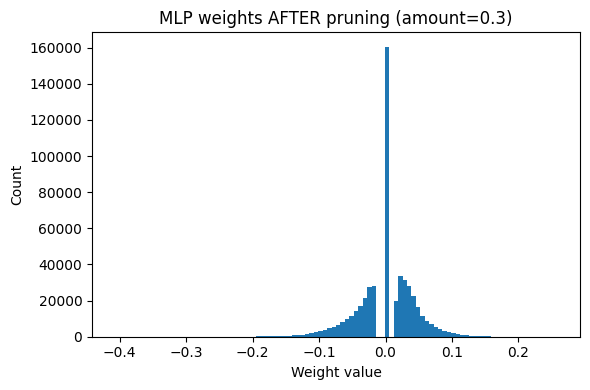

Accuracy after pruning (pre-finetune): 0.9807
Epoch 01 | train_loss=0.0305 | test_acc=0.9821
Epoch 02 | train_loss=0.0223 | test_acc=0.9834
Accuracy after fine-tune: 0.9834
\n=== MLP: pruning amount=0.5 ===


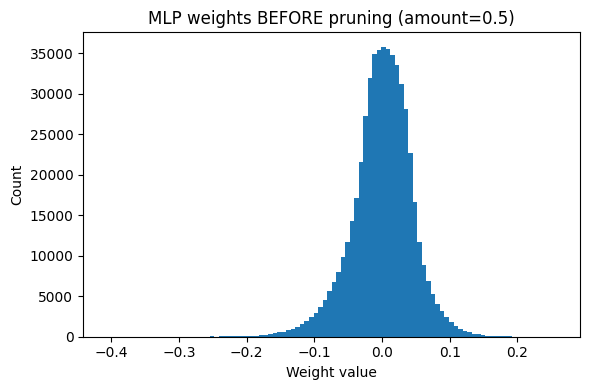

Sparsity after pruning: 0.5000 (nonzero=267520/535040)


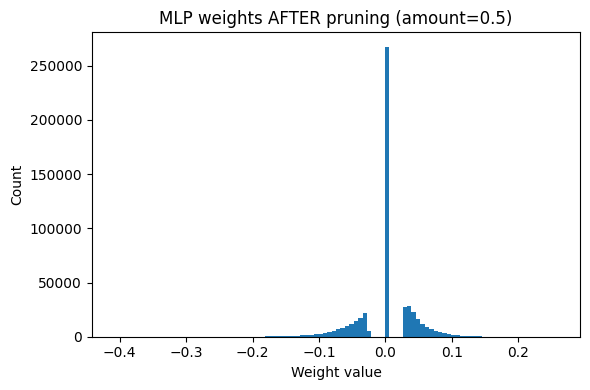

Accuracy after pruning (pre-finetune): 0.9802
Epoch 01 | train_loss=0.0279 | test_acc=0.9839
Epoch 02 | train_loss=0.0219 | test_acc=0.9855
Accuracy after fine-tune: 0.9855
\n=== MLP: pruning amount=0.7 ===


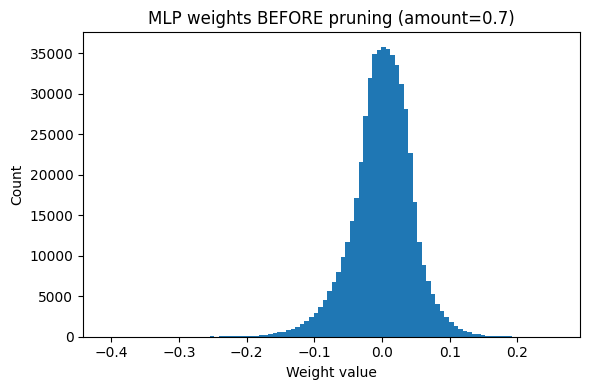

Sparsity after pruning: 0.7000 (nonzero=160512/535040)


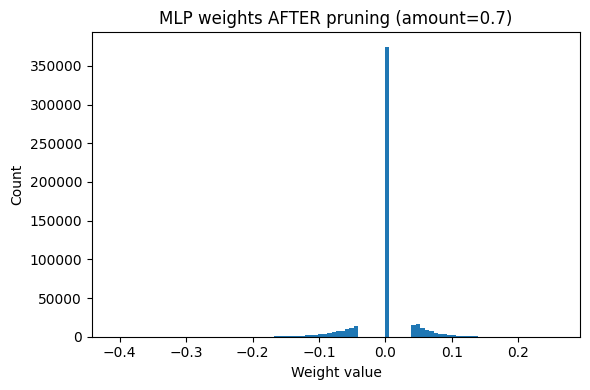

Accuracy after pruning (pre-finetune): 0.9774
Epoch 01 | train_loss=0.0331 | test_acc=0.9852
Epoch 02 | train_loss=0.0228 | test_acc=0.9843
Accuracy after fine-tune: 0.9843
\n=== MLP: pruning amount=0.9 ===


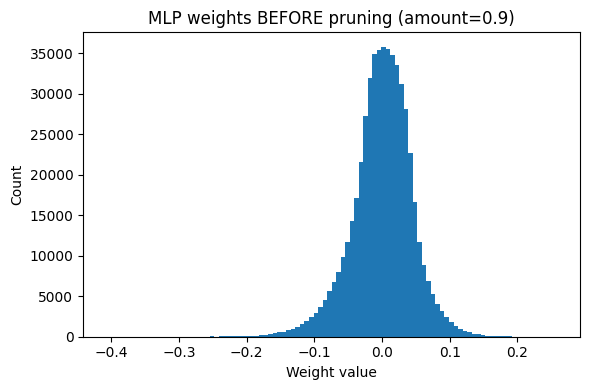

Sparsity after pruning: 0.9000 (nonzero=53504/535040)


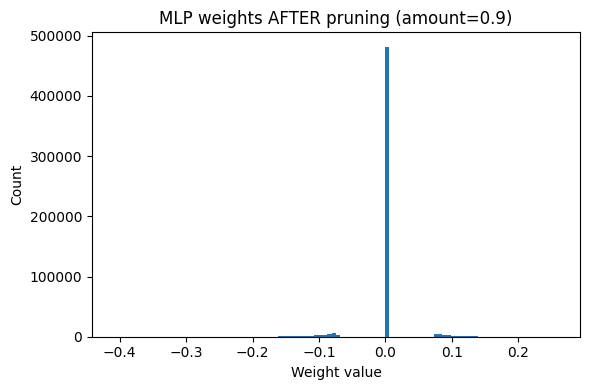

Accuracy after pruning (pre-finetune): 0.9619
Epoch 01 | train_loss=0.0973 | test_acc=0.9817
Epoch 02 | train_loss=0.0528 | test_acc=0.9828
Accuracy after fine-tune: 0.9828
\n=== MLP: pruning amount=0.99 ===


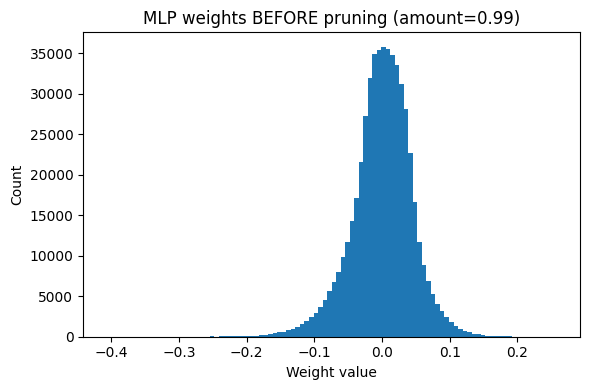

Sparsity after pruning: 0.9900 (nonzero=5350/535040)


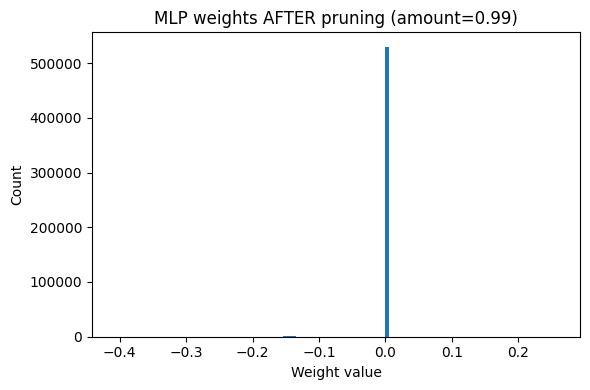

Accuracy after pruning (pre-finetune): 0.1270
Epoch 01 | train_loss=1.7995 | test_acc=0.7924
Epoch 02 | train_loss=0.9408 | test_acc=0.8786
Accuracy after fine-tune: 0.8786


,model,prune_amount,baseline_acc,acc_after_prune,acc_after_finetune,sparsity
0,MLP,0.30,0.9805,0.9807,0.9834,0.300000
1,MLP,0.50,0.9805,0.9802,0.9855,0.500000
2,MLP,0.70,0.9805,0.9774,0.9843,0.700000
3,MLP,0.90,0.9805,0.9619,0.9828,0.900000
4,MLP,0.99,0.9805,0.1270,0.8786,0.990001


In [ ]:

# Run MLP
df_mlp = run_pruning_experiments(MLP, train_loader, test_loader, base_epochs=5, finetune_epochs=2,
                                 base_lr=1e-3, finetune_lr=5e-4,
                                 prune_amounts=(0.3,0.5,0.7,0.9,0.99), label="MLP")
df_mlp


# We obzerve zero spike after PyTorch pruning because Prunable weights are set to exactly 0, so the histogram’s bin at 0 shoots up. They don’t “vanish” because PyTorch pruning doesn’t delete parameters but it masks them to zero (and even after `prune.remove`, the tensor keeps the same shape; zeros stay stored).




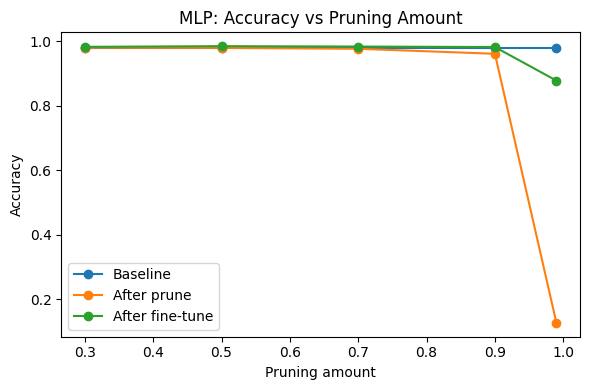

In [ ]:

# Plot MLP acc vs pruning
def plot_acc(df, title):
    x = df["prune_amount"].values
    plt.figure(figsize=(6,4))
    plt.plot(x, df["baseline_acc"].values, marker="o", label="Baseline")
    plt.plot(x, df["acc_after_prune"].values, marker="o", label="After prune")
    plt.plot(x, df["acc_after_finetune"].values, marker="o", label="After fine-tune")
    plt.xlabel("Pruning amount"); plt.ylabel("Accuracy"); plt.title(title)
    plt.legend(); plt.tight_layout(); plt.show()

plot_acc(df_mlp, "MLP: Accuracy vs Pruning Amount")


=== CNN: baseline training ===
Epoch 01 | train_loss=0.1750 | test_acc=0.9839
Epoch 02 | train_loss=0.0661 | test_acc=0.9882
Epoch 03 | train_loss=0.0508 | test_acc=0.9894
Epoch 04 | train_loss=0.0407 | test_acc=0.9903
Epoch 05 | train_loss=0.0370 | test_acc=0.9891
CNN baseline test accuracy: 0.9891
\n=== CNN: pruning amount=0.3 ===


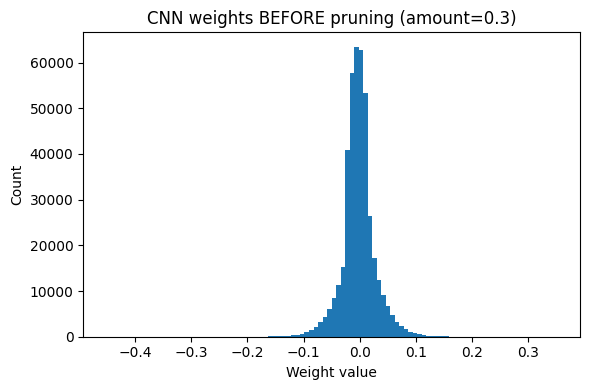

Sparsity after pruning: 0.3000 (nonzero=294986/421408)


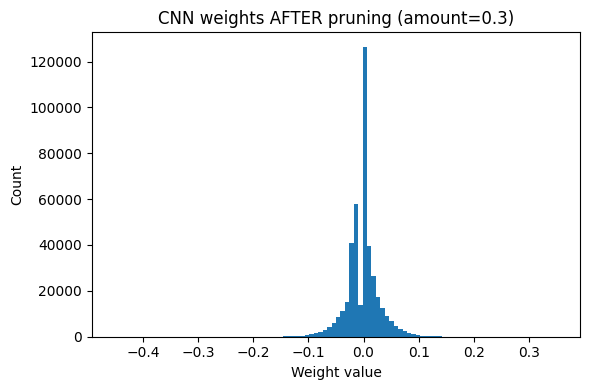

Accuracy after pruning (pre-finetune): 0.9890
Epoch 01 | train_loss=0.0243 | test_acc=0.9925
Epoch 02 | train_loss=0.0182 | test_acc=0.9924
Accuracy after fine-tune: 0.9924
\n=== CNN: pruning amount=0.5 ===


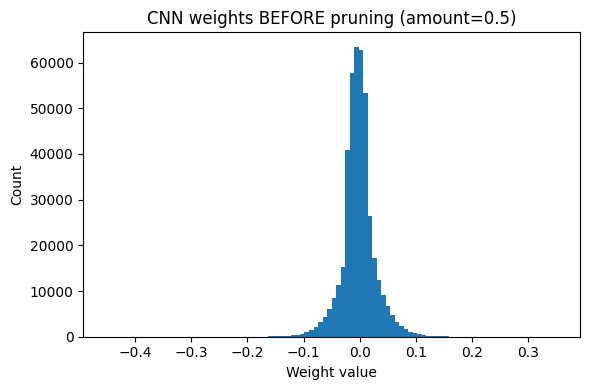

Sparsity after pruning: 0.5000 (nonzero=210704/421408)


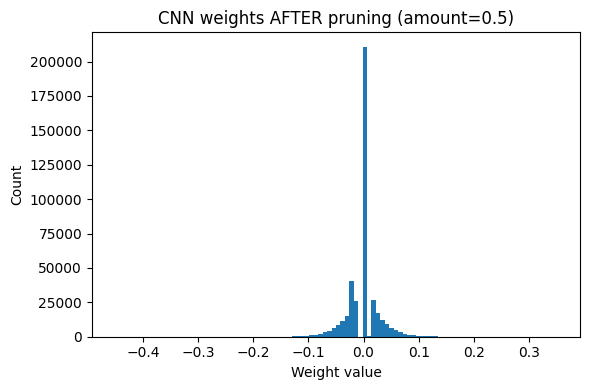

Accuracy after pruning (pre-finetune): 0.9888
Epoch 01 | train_loss=0.0223 | test_acc=0.9920
Epoch 02 | train_loss=0.0176 | test_acc=0.9913
Accuracy after fine-tune: 0.9913
\n=== CNN: pruning amount=0.7 ===


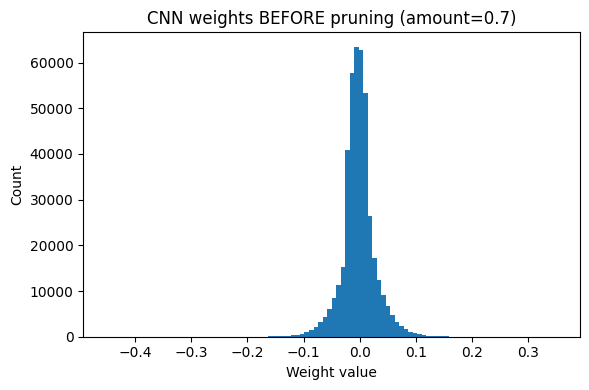

Sparsity after pruning: 0.7000 (nonzero=126422/421408)


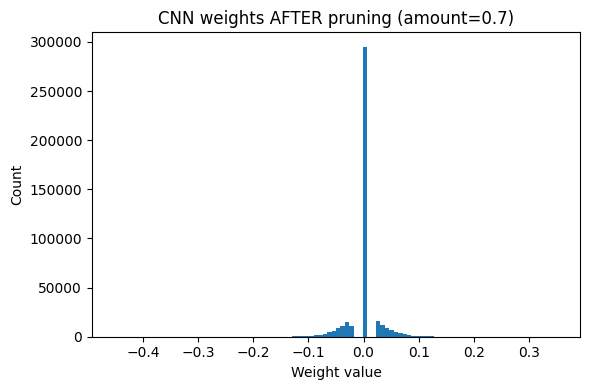

Accuracy after pruning (pre-finetune): 0.9896
Epoch 01 | train_loss=0.0214 | test_acc=0.9926
Epoch 02 | train_loss=0.0181 | test_acc=0.9932
Accuracy after fine-tune: 0.9932
\n=== CNN: pruning amount=0.9 ===


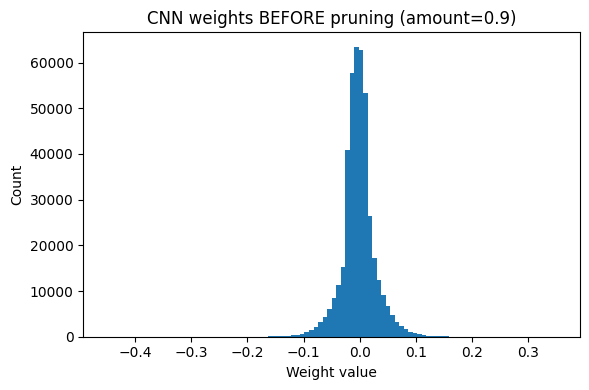

Sparsity after pruning: 0.9000 (nonzero=42141/421408)


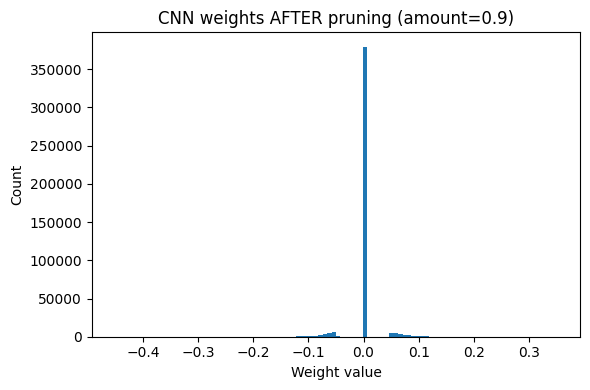

Accuracy after pruning (pre-finetune): 0.9744
Epoch 01 | train_loss=0.0278 | test_acc=0.9922
Epoch 02 | train_loss=0.0207 | test_acc=0.9933
Accuracy after fine-tune: 0.9933
\n=== CNN: pruning amount=0.99 ===


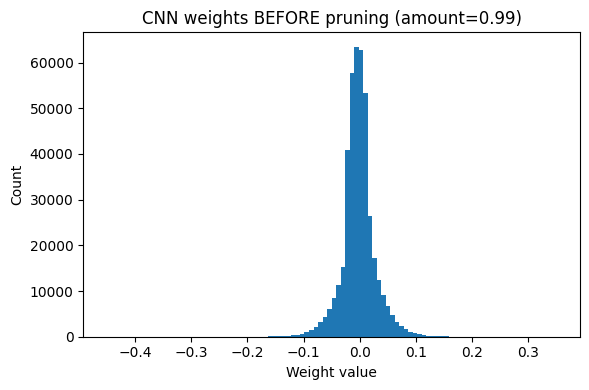

Sparsity after pruning: 0.9900 (nonzero=4214/421408)


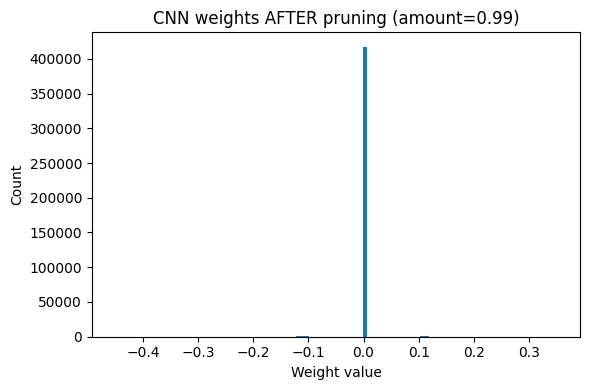

Accuracy after pruning (pre-finetune): 0.2949
Epoch 01 | train_loss=0.8200 | test_acc=0.9654
Epoch 02 | train_loss=0.2415 | test_acc=0.9738
Accuracy after fine-tune: 0.9738


,model,prune_amount,baseline_acc,acc_after_prune,acc_after_finetune,sparsity
0,CNN,0.30,0.9891,0.9890,0.9924,0.299999
1,CNN,0.50,0.9891,0.9888,0.9913,0.500000
2,CNN,0.70,0.9891,0.9896,0.9932,0.700001
3,CNN,0.90,0.9891,0.9744,0.9933,0.900000
4,CNN,0.99,0.9891,0.2949,0.9738,0.990000


In [ ]:

# Run CNN
df_cnn = run_pruning_experiments(SimpleCNN, train_loader, test_loader, base_epochs=5, finetune_epochs=2,
                                 base_lr=1e-3, finetune_lr=5e-4,
                                 prune_amounts=(0.3,0.5,0.7,0.9,0.99), label="CNN")
df_cnn


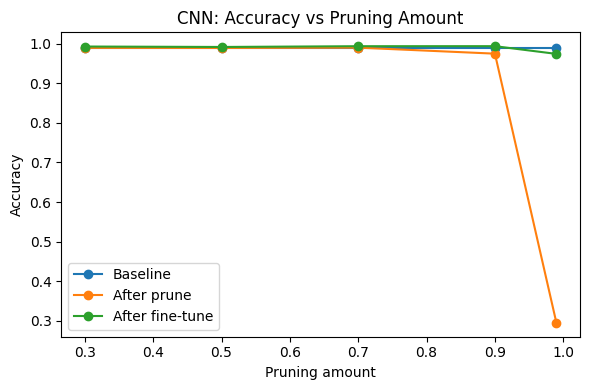

In [ ]:

# Plot CNN acc vs pruning
plot_acc(df_cnn, "CNN: Accuracy vs Pruning Amount")


In [ ]:

# Save CSVs
import os
os.makedirs("results", exist_ok=True)
df_mlp.to_csv("results/mlp_pruning_results.csv", index=False)
df_cnn.to_csv("results/cnn_pruning_results.csv", index=False)
print("Saved:", "results/mlp_pruning_results.csv", "and", "results/cnn_pruning_results.csv")


Saved: results/mlp_pruning_results.csv and results/cnn_pruning_results.csv
